In [27]:
import logging
import os
import sys
from monai.networks.nets import DenseNet121
import matplotlib.pyplot as plt
import torch
# from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensity,
)
import torch.nn.functional as F
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 1.4.0
Numpy version: 1.26.3
Pytorch version: 2.2.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: f:\Anaconda3\envs\monai\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.12.0
Pillow version: 10.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.0+cpu
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.0
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version

In [2]:
def get_model(in_channel = 1, out_channels = 3):
    return DenseNet121(
        spatial_dims=3,  # 3D input
        in_channels=in_channel,   # Typically for grayscale (e.g., MRI/CT scans), change to 3 for RGB
        out_channels=out_channels   # Adjust for binary or multi-class segmentation/classification
    )

In [3]:
device = torch.device('cuda:0')
model = get_model(out_channels = 3)
model.load_state_dict(torch.load(r'F:\Myproject\IPMN_classifation\fold5_best_auc_model.pth',map_location='cuda:0') )
model.to(device)
model.eval()

DenseNet121(
  (features): Sequential(
    (conv0): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (norm0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (norm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
 

In [4]:

test_transforms = Compose([ScaleIntensity(), EnsureChannelFirst(), Resize((96, 96, 96))])
test_ds = ImageDataset(image_files=[r'D:\IPMN\sample_images\t2_clean_roi\MCF_28.nii.gz'], labels=[2], transform=test_transforms)
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=False)

In [5]:


itera = iter(test_dataloader)
def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

In [6]:
img, label = get_next_im()

torch.Size([1, 1, 96, 96])

torch.Size([1, 1, 96, 96, 96])


100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


torch.Size([1, 1, 96, 96])


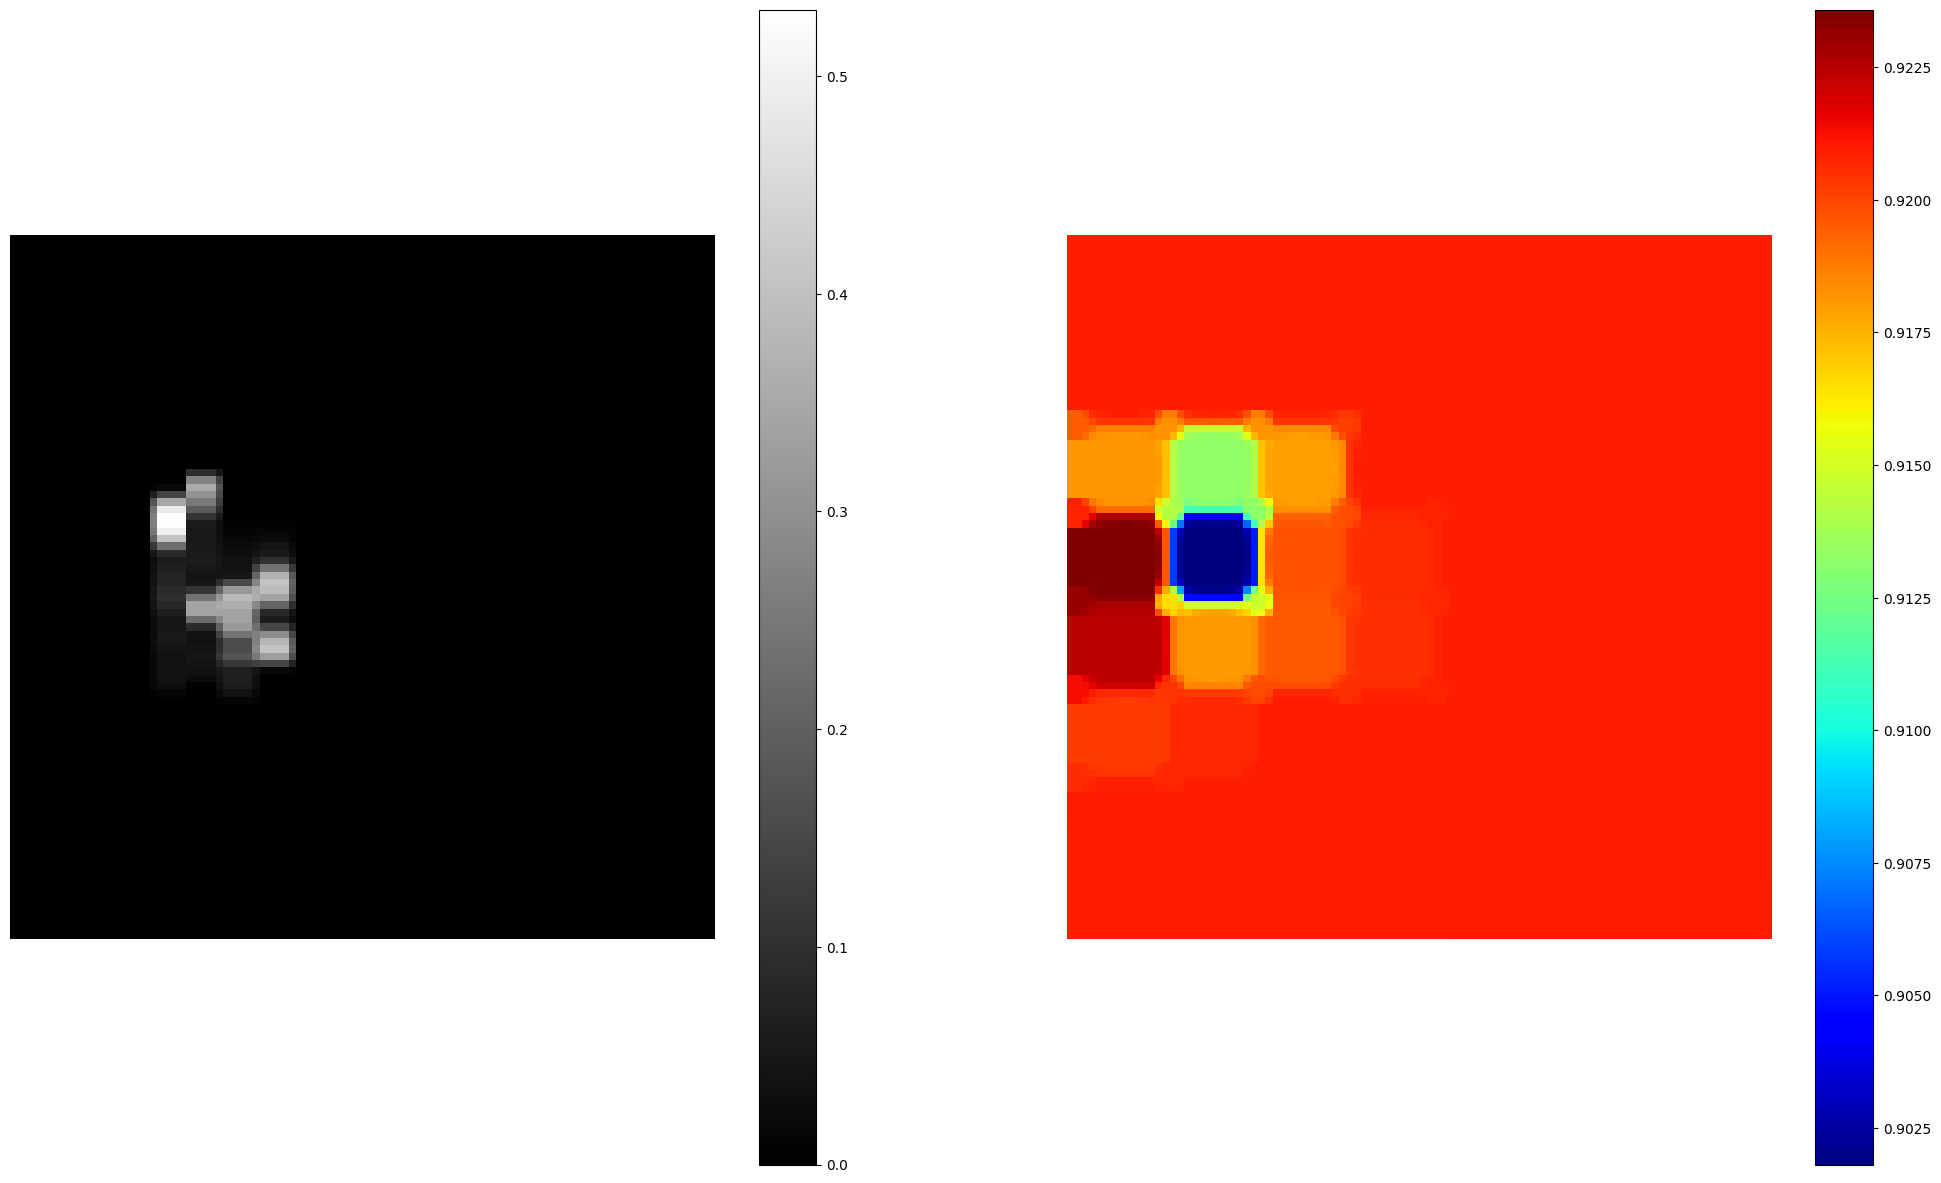

In [58]:
# Get the occlusion sensitivity map
occ_sens = monai.visualize.OcclusionSensitivity(nn_module=model, n_batch=10)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
# Image shape b,c,d,h,w
print(img.shape)
# depth_slice = img.shape[2] // 2
depth_slice = 70
heat_map_slices = []
# for depth_slice in range(96):
#     occ_sens_b_box = [depth_slice, depth_slice, -1, -1, -1, -1]

#     occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)

#     occ_result = occ_result[0, label.argmax().item()][None]
#     print(occ_result.shape)
#     heat_map_slices.append(occ_result)

occ_sens_b_box = [depth_slice-1, depth_slice, -1, -1, -1, -1]

occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)

occ_result = occ_result[0, label.argmax().item()][None]
print(occ_result.shape)
heat_map_slices.append(occ_result)
# heat_map = torch.stack(tensor_list, dim=2)


# stacked_tensor = torch.stack(tensor_list, dim=2)

# print(stacked_tensor.shape)

fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)

In [43]:
heat_map_slices[0].shape

torch.Size([1, 96, 96, 96])

In [41]:
heat_map = torch.stack(heat_map = torch.stack(heat_map_slices, dim=2), dim=2)

RuntimeError: stack expects each tensor to be equal size, but got [1, 96, 96, 96] at entry 0 and [1, 1, 96, 96] at entry 1

In [ ]:
resized_tensor = F.interpolate(img, size=(177, 99, 20), mode='trilinear', align_corners=False)

In [ ]:
restored_img = resized_tensor.squeeze().cpu()

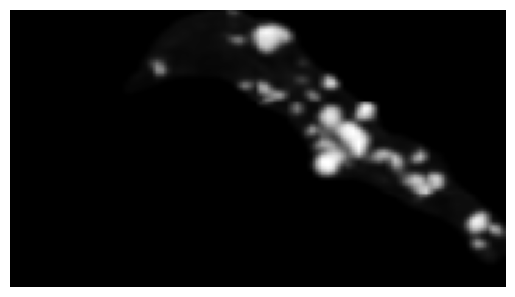

In [38]:
img_slice = restored_img[:,:,5]
img_slice = np.rot90(img_slice, k=1)
plt.imshow(img_slice, cmap="gray", origin="lower") 
plt.axis("off")  # Turn off axis labels for better visualization
plt.show()